<a href="https://colab.research.google.com/github/MatP-DS/MasterThesis/blob/main/rf_model_precomparison_for_satellite_data3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import numpy as np
import pandas as pd
import shutil
import os
import time
from google.colab import drive
drive.mount('/content/drive')

# Paths to source data in Google Drive
drive_base = '/content/drive/MyDrive/MasterThesis/02_preprocessed_data'
local_base = '/content'


Mounted at /content/drive


In [ ]:
# Copy files to Colab local environment for faster access
shutil.copy(f"{drive_base}/training_data-full_S2_2023_07.npz", f"{local_base}/s2.npz")
shutil.copy(f"{drive_base}/training_data-full_L8_2023_07.npz", f"{local_base}/l8.npz")


'/content/l8.npz'

In [ ]:
# Load data from local files
s2 = np.load(f"{local_base}/s2.npz")
l8 = np.load(f"{local_base}/l8.npz")

X_s2, y_s2 = s2['X'], s2['y']
X_l8, y_l8 = l8['X'], l8['y']


In [ ]:

# Split into train and test sets
X_s2_train, X_s2_test, y_s2_train, y_s2_test = train_test_split(
    X_s2, y_s2, test_size=0.2, stratify=y_s2, random_state=42)

X_l8_train, X_l8_test, y_l8_train, y_l8_test = train_test_split(
    X_l8, y_l8, test_size=0.2, stratify=y_l8, random_state=42)

results = {}


In [ ]:
# Sentinel-2 model training and evaluation
start_s2 = time.time()
rf_s2 = RandomForestClassifier(n_estimators=100, random_state=42)
rf_s2.fit(X_s2_train, y_s2_train)
s2_preds_train = rf_s2.predict(X_s2_train)
s2_preds_test = rf_s2.predict(X_s2_test)
train_report_s2 = classification_report(y_s2_train, s2_preds_train, output_dict=True)
test_report_s2 = classification_report(y_s2_test, s2_preds_test, output_dict=True)

results["Sentinel-2 (Train)"] = {
    "Accuracy": (s2_preds_train == y_s2_train).mean(),
    "F1 (loss)": train_report_s2['1']['f1-score'],
    "Recall (loss)": train_report_s2['1']['recall'],
    "Precision (loss)": train_report_s2['1']['precision'],
    "Training Time (s)": round(time.time() - start_s2, 2)
}

results["Sentinel-2 (Test)"] = {
    "Accuracy": (s2_preds_test == y_s2_test).mean(),
    "F1 (loss)": test_report_s2['1']['f1-score'],
    "Recall (loss)": test_report_s2['1']['recall'],
    "Precision (loss)": test_report_s2['1']['precision'],
    "Training Time (s)": None  # Only counted in training row
}

# Landsat 8 model training and evaluation
start_l8 = time.time()
rf_l8 = RandomForestClassifier(n_estimators=100, random_state=42)
rf_l8.fit(X_l8_train, y_l8_train)
l8_preds_train = rf_l8.predict(X_l8_train)
l8_preds_test = rf_l8.predict(X_l8_test)
train_report_l8 = classification_report(y_l8_train, l8_preds_train, output_dict=True)
test_report_l8 = classification_report(y_l8_test, l8_preds_test, output_dict=True)

results["Landsat 8 (Train)"] = {
    "Accuracy": (l8_preds_train == y_l8_train).mean(),
    "F1 (loss)": train_report_l8['1']['f1-score'],
    "Recall (loss)": train_report_l8['1']['recall'],
    "Precision (loss)": train_report_l8['1']['precision'],
    "Training Time (s)": round(time.time() - start_l8, 2)
}

results["Landsat 8 (Test)"] = {
    "Accuracy": (l8_preds_test == y_l8_test).mean(),
    "F1 (loss)": test_report_l8['1']['f1-score'],
    "Recall (loss)": test_report_l8['1']['recall'],
    "Precision (loss)": test_report_l8['1']['precision'],
    "Training Time (s)": None
}

comparison_df = pd.DataFrame(results)


In [ ]:
print(comparison_df)

                   Sentinel-2 (Train)  Sentinel-2 (Test)  Landsat 8 (Train)  \
Accuracy                     0.999995           0.998958           0.999995   
F1 (loss)                    0.998538           0.514768           0.998540   
Recall (loss)                0.997080           0.356725           0.998540   
Precision (loss)             1.000000           0.924242           0.998540   
Training Time (s)          144.010000                NaN         118.440000   

                   Landsat 8 (Test)  
Accuracy                   0.999094  
F1 (loss)                  0.606299  
Recall (loss)              0.450292  
Precision (loss)           0.927711  
Training Time (s)               NaN  


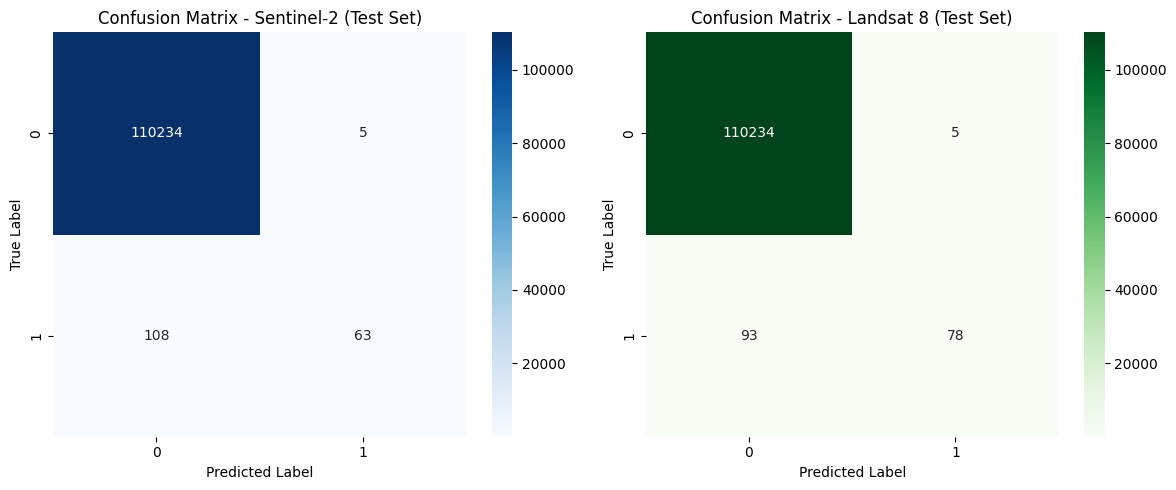

In [ ]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Compute confusion matrices
cm_s2 = confusion_matrix(y_s2_test, s2_preds_test)
cm_l8 = confusion_matrix(y_l8_test, l8_preds_test)

# Create subplot with two confusion matrices
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Sentinel-2
sns.heatmap(cm_s2, annot=True, fmt='d', cmap='Blues', ax=axes[0])
axes[0].set_title("Confusion Matrix - Sentinel-2 (Test Set)")
axes[0].set_xlabel("Predicted Label")
axes[0].set_ylabel("True Label")

# Landsat 8
sns.heatmap(cm_l8, annot=True, fmt='d', cmap='Greens', ax=axes[1])
axes[1].set_title("Confusion Matrix - Landsat 8 (Test Set)")
axes[1].set_xlabel("Predicted Label")
axes[1].set_ylabel("True Label")

plt.tight_layout()
plt.show()